In [ ]:
!git clone https://github.com/AhMuGeoNa/2022-AI-Competition.git

In [ ]:
!cp -r 2022-AI-Competition/data data
!mkdir data/csv
!mkdir data/zips
!cp -r train.zip data/zips/train.zip

In [ ]:
!mv data/train.csv data/csv/train.csv
!mv data/test.csv data/csv/test.csv
!mv data/valid.csv data/csv/valid.csv

!unzip data/zips/train.zip -d data/images

In [12]:
## 데이터 처리에 필요한 패키지 로드
from imutils.paths import list_images
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
import cv2, os
import shutil

# **1.데이터셋 전처리**
- 전체 이미지 데이터 셋 10,000장
- 학습 : 시험 : 검증 = 6 : 2 : 2로 분할
- 이미지 중에서 어두운 이미지가 존재하여 이미지 평탄화 진행

In [20]:
images_path = 'data/images/train'
csv_path    = 'data/csv'

## csv 파일에 존재하는 정보들을 기반으로하여 라벨별로 데이터 정리하는 함수
def data_organizer(dtype = 'train'):
  df = pd.read_csv(f'{csv_path}/{dtype}.csv')

  for image_path, grade in zip(df['imname'], df['grade']):
    os.makedirs(f'data/{dtype}/{grade}', exist_ok = True)
    shutil.copy(f'{images_path}/{grade}/{image_path}', f'data/{dtype}/{grade}/{image_path}')

data_organizer()
data_organizer(dtype = 'test')
data_organizer(dtype = 'valid')

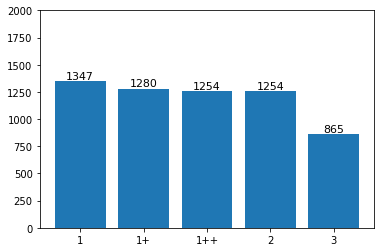

In [21]:
## 데이터 분포 확인하는 함수
def data_distribution(data_path):
  ## data_path에 있는 이미지 목록을 리스트로 불러오는 부분.
  image_paths = sorted(list_images(data_path))

  ## 이미지 경로에서 '/'을 기준으로 나눈것 중 마지막에서 2번째 값만 가져옴. (라벨값만 가져옴.)
  ## (e.g.) data/train/1++/cow_1++_1002.jpg => 1++
  image_paths = [image_path.split(os.path.sep)[-2] for image_path in image_paths]

  ## 라벨별 개수를 반환해주는 부분 (딕셔너리 형태로 만들어짐)
  label_count = Counter(image_paths)
  label_count = dict(sorted(label_count.items()))

  ## 레이블 별 데이터 분포를 시각화 시키는 코드
  plt.bar(label_count.keys(), label_count.values())
  plt.ylim(0, 2000)

  for grade, num in label_count.items():
      plt.text(
                  grade, num, num,
                  fontsize = 11, color = 'black',
                  horizontalalignment = 'center',
                  verticalalignment = 'bottom'
              )
  plt.show()
  return label_count
## 3등급 이미지가 다른 이미지들에 비해 수가 적은 것을 보임.
## 일단 그냥 한 번 돌려보고 성능이 제대로 나오지 않을 경우에 불균형 해소후 학습
train_label_count = data_distribution('data/train')

In [22]:
## 라벨을 인덱스 값으로 변경
label2idx = {'1++' : 0, '1+' : 1, '1' :2, '2' :3, '3': 4}
print(label2idx)

{'1++': 0, '1+': 1, '1': 2, '2': 3, '3': 4}


In [88]:
## 이미지 전처리 해주는 함수
def preprocessing(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    ycrcb_planes = list(cv2.split(image))


    # 밝기 성분에 대해서만 히스토그램 평활화 수행
    ycrcb_planes[0] = cv2.equalizeHist(ycrcb_planes[0])

    image = cv2.merge(ycrcb_planes)
    image = cv2.cvtColor(image, cv2.COLOR_YCrCb2RGB)

    return image

datasets = {}
## 전처리한 이미지를 넘파이 배열로 만들어주는 함수
def build_dataset(data_path, dtype = 'train'):
  image_paths = sorted(list_images(data_path))

  images, labels = [], []
  for image_path in image_paths:

    image = cv2.imread(image_path)
    image = preprocessing(image)
    
    images.append(image)
    labels.append(label2idx[image_path.split(os.path.sep)[-2]])

  datasets[dtype] = [np.array(images), np.array(labels)]
  return datasets

datasets = build_dataset('data/train')
datasets = build_dataset('data/test', dtype = 'test')
datasets = build_dataset('data/valid', dtype = 'valid')

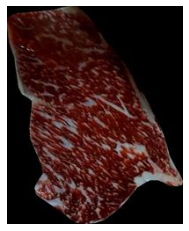

In [24]:
## 원본 이미지
image = cv2.imread('data/train/1++/cow_1++_1074.jpg')
plt.axis(False)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

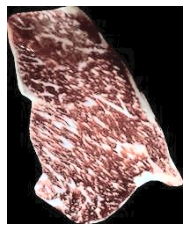

In [25]:
## 전처리한 이미지
image = preprocessing(image)

plt.axis(False)
plt.imshow(image)

# **2. 학습 진행하기**
## **2-1. 데이터 셋 구성하기**
- opencv로 구성한 데이터 셋을 pytorch 데이터 셋으로 변경

#### **데이터 셋 픽셀 평균, 표준편차 값 구해주는 함수 참조**
- Inhovative AI | 3. (1) 이미지 전처리 - augmentation, normalization | [[블로그 주소]]('https://inhovation97.tistory.com/37')

In [32]:
## 사전 학습된 모델을 불러오는 패키지
!pip install timm

In [27]:
!pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'

  Cloning https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup to /tmp/pip-req-build-hkmjkvne
  Running command git clone --filter=blob:none -q https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup /tmp/pip-req-build-hkmjkvne
  Resolved https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup to commit 2958117072f214dce743f918d6a2253f682ab65d
  Preparing metadata (setup.py) ... done
  Created wheel for cosine-annealing-warmup: filename=cosine_annealing_warmup-2.0-py3-none-any.whl size=3334 sha256=3aaae2473a75ba1961610c101d088a93be876f2cf9106523269662b2b3f8eb31
  Stored in directory: /tmp/pip-ephem-wheel-cache-lzv28brd/wheels/a6/ce/7d/6fe229886a381b3af560c1d75942eff933a959781ff693b89b
Successfully built cosine-annealing-warmup


In [35]:
## 신경망 구성에 필요한 패키지 로드
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset
from torch.optim import Adam, AdamW
from torchvision import transforms
import torch.nn.functional as F
from torchvision import utils
import torch.nn as nn
import torch
import timm
import gc

In [330]:
NUM_CLASSES     = 5
SEED            = 99
DEVICE          = 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_WORKERS     = 1
PIN_MEMORY      = True

DROPOUT_RATE    = 0.5
EPOCHS          = 100
BATCH_SIZE      = 32
LR              = 1e-3
CLIP_GRAD       = 10
PATIENCE        = 15

In [156]:
## 데이터셋 픽셀 평균, 표준편차 값 구해주는 함수
def get_mean_std(dataset):
  to_tensor = transforms.Compose([
                                  transforms.ToPILImage(),
                                  transforms.ToTensor()
                                ])
  dataset = [to_tensor(data) for data in dataset]
  
  meanRGB = [np.mean(image.numpy(), axis=(1, 2)) for image in dataset]
  stdRGB  = [np.std(image.numpy(), axis=(1, 2)) for image in dataset]

  meanR = np.mean([m[0] for m in meanRGB])
  meanG = np.mean([m[1] for m in meanRGB])
  meanB = np.mean([m[2] for m in meanRGB])

  stdR = np.mean([s[0] for s in stdRGB])
  stdG = np.mean([s[1] for s in stdRGB])
  stdB = np.mean([s[2] for s in stdRGB])

  return {'mean' : (meanR, meanG, meanB), 'std' : (stdR, stdG, stdB)}


In [333]:
## 커스텀 데이터셋 생성
class BeafData(Dataset):

  def __init__(self, images, labels, mean_n_std, dtype = 'train'):

    self.images = images
    self.labels = labels
    self.dtype  = dtype
    
    self.transform = {}
    self.transform['train'] = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((240, 240)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean_n_std['mean'], mean_n_std['std'])             
                              ])
    self.transform['test'] = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((240, 240)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean_n_std['mean'], mean_n_std['std'])          
                          ])

    self.transform['valid'] = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.Resize((240, 240)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean_n_std['mean'], mean_n_std['std'])          
                      ])

    self.num_datas = self.labels.shape[0]

  ## 이미지, 라벨 데이터를 튜플형태로 변환
  def __getitem__(self, index):
    image = self.images[index]

    image = self.transform[self.dtype](image)
    return image, self.labels[index]

  def __len__(self):
    return self.num_datas

In [334]:
train_images, train_labels = datasets['train']
train_mean_n_std = get_mean_std(train_images)
print(train_mean_n_std)

{'mean': (0.43284187, 0.31426674, 0.30875233), 'std': (0.3776003, 0.3116054, 0.31011364)}


In [335]:
## 데이터 불균형 문제로 로스가 안떨이지는 것으로 가정하고, 학습 진행해보기
class_counts  = [count for count in train_label_count.values()]
total_samples = sum(class_counts)

## labels        | 학습 데이터 셋의 라벨인덱스 값들 [0, 0, 0, 0, ..., 4, 4, 4, 4]
## class_weights | 라벨별 가중치 설정 (수가 적은 라벨에 더 많은 가중치 부여)
labels = [lb for lb in train_labels.data]
class_weights = [total_samples / class_count for class_count in class_counts]
weights = [class_weights[lb_idx] for lb_idx in labels]

sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(total_samples))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 240, 240])


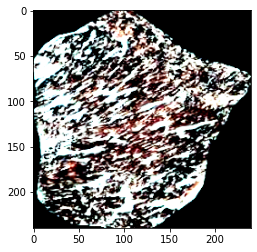

In [336]:
train_dataset = BeafData(train_images, train_labels, mean_n_std = train_mean_n_std)
train_loader  = DataLoader(train_dataset, batch_size = BATCH_SIZE,
                           sampler = sampler, pin_memory = PIN_MEMORY, num_workers = NUM_WORKERS)

data_iter = iter(train_loader)

images, labels = next(data_iter)
image = images[0]

print(image.shape)
plt.imshow(np.transpose(image, (1, 2, 0)))

In [337]:
valid_images, valid_labels = datasets['valid']
valid_mean_n_std = get_mean_std(valid_images)
print(valid_mean_n_std)

{'mean': (0.43203428, 0.31337285, 0.30804688), 'std': (0.37785816, 0.3113508, 0.30983475)}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 240, 240])


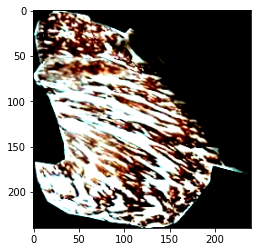

In [338]:
valid_dataset = BeafData(valid_images, valid_labels, mean_n_std = valid_mean_n_std, dtype = 'valid')
valid_loader  = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = False)

data_iter = iter(valid_loader)
images, labels = next(data_iter)
image = images[0]

print(image.shape)
plt.imshow(np.transpose(image, (1, 2, 0)))

## **2-2. 신경망 구성하기**
- timm을 이용한 사전 학습모델 사용하여 신경망 구성
- 이미지 데이터가 248 x 200 이미지 이므로,   
  사전 학습 모델의 입력 사이즈가 240 x 240인 것으로 테스트 해보기  

#### **Timm 사용법, 학습 과정 참조**
- 프로그래머스 공식 블로그 | [[블로그 주소]](https://prgms.tistory.com/75)

In [161]:
## efficientnet 목록
timm.list_models('*res*')

['bat_resnext26ts',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'cspresnext50_iabn',
 'dla60_res2net',
 'dla60_res2next',
 'eca_resnet33ts',
 'eca_resnext26ts',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet200d',
 'ecaresnet269d',
 'ecaresnetlight',
 'ecaresnext26t_32x4d',
 'ecaresnext50t_32x4d',
 'ens_adv_inception_resnet_v2',
 'gcresnet33ts',
 'gcresnet50t',
 'gcresnext26ts',
 'gcresnext50ts',
 'gluon_resnet18_v1b',
 'gluon_resnet34_v1b',
 'gluon_resnet50_v1b',
 'gluon_resnet50_v1c',
 'gluon_resnet50_v1d',
 'gluon_resnet50_v1s',
 'gluon_resnet101_v1b',
 'gluon_resnet101_v1c',
 'gluon_resnet101_v1d',
 'gluon_resnet101_v1s',
 'gluon_resnet152_v1b',
 'gluon_resnet152_v1c',
 'gluon_resnet152_v1d',
 'gluon_resnet152_v1s',
 'gluon_resnext50_32x4d',
 'gluon_resnext101_32x4d',
 'gluon_resnext101_64x4d',
 'gluon_seresnext50_32x4d',
 'gluon_seresnext101_32x4d',
 'gluon_seresnext101_64x4d

In [359]:
 ## 신경망 fine-tunning
class EffNet(nn.Module):
  def __init__(self,num_classes):
    super(EffNet, self).__init__()
    
    if os.path.isfile('models/best_model.pt'):
        print('BEST MODEL LOAD')
        self.model = torch.load('models/best_model.pt')
        
    else:
        print('PRE-TRAINED MODEL LOAD')
        self.model = timm.create_model('resnetv2_101', pretrained = True)

        # num_features = self.model.fc.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features = 2048, out_features = 640),
            nn.ReLU(),
            nn.Dropout(p = DROPOUT_RATE),
            nn.Linear(in_features = 640, out_features = 256),
            nn.ReLU(),
            nn.Dropout(p = DROPOUT_RATE),
            nn.Linear(in_features = 256, out_features = 64),
            nn.ReLU(),
            nn.Linear(in_features = 64, out_features = num_classes)
        )

    
  def forward(self, x):
    output = self.model(x)
    return output

In [360]:
## 손실함수 정의
criterion = nn.CrossEntropyLoss()

## 최적화 함수 가져오는 함수
def get_optim(model):
  optim = AdamW(model.parameters(), lr = LR, weight_decay = 5e-6)

  ## 모든 파라미터들의 grad값을 0으로 초기화
  optim.zero_grad()
  return optim

## 러닝레이트 스케줄러함수
def get_scheduler(optim):
  scheduler = CosineAnnealingWarmupRestarts(optim, first_cycle_steps = 10, cycle_mult = 1, max_lr = 0.1, min_lr = 0.0001, warmup_steps = 5, gamma = 0.5)
  return scheduler

## 학습 함수
def train(model, train_loader, optim):
  model.train()
  corrects, total_loss = 0, 0
 
  for (images, labels) in train_loader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()

    optim.step()
    optim.zero_grad()

    _, preds = torch.max(outputs, 1)
    corrects += torch.sum(preds == labels.data)
    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  acc = corrects / (len(train_loader)*BATCH_SIZE)

  print(f'Train Accuracy : {acc:.3f} | Train Loss : {avg_loss:.3f}')
  return acc

## 검증 함수
def validation(model, valid_loader):
  model.eval()
  corrects, total_loss = 0, 0

  for (images, labels) in valid_loader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    outputs = model(images)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs, 1)
    corrects += torch.sum(preds == labels.data)
    total_loss += loss.item()

  avg_loss = total_loss / len(valid_loader)
  acc = corrects / (len(valid_loader)*BATCH_SIZE)
  print(f'Valid Accuracy : {acc:.3f} | Valid Loss : {avg_loss:.3f}\n')

  return acc, outputs

In [361]:
## 훈련 사이클 함수
def run(model, train_loader, valid_loader):
  optim     = get_optim(model)
  # scheduler = get_scheduler(optim)

  early_stopping_counter = 0
  best_acc               = -1

  for epoch in range(EPOCHS):
    print(f'[{epoch + 1} / {EPOCHS}]')

    train_acc          = train(model, train_loader, optim)
    valid_acc, outputs = validation(model, valid_loader)

    if valid_acc > best_acc:
        os.makedirs('models/', exist_ok = True)
        
        best_acc               = valid_acc
        early_stopping_counter = 0
        
        torch.save(model, 'models/best_model.pt')
        print(f'save model with accuracy : {best_acc}')

    else:
        early_stopping_counter += 1
        if early_stopping_counter >= PATIENCE:
            print(f'Training Stopped by Early stopping counter : {early_stopping_counter}')
            break

    optim.step()

In [362]:
## 캐시 메모리 비우기 및 가비지 컬렉터 실행
## 모델 여러번 학습시키고 나면 메모리에 남는 찌꺼기들 제거해주는 코드
torch.cuda.empty_cache()
gc.collect()


model = EffNet(num_classes = NUM_CLASSES)
model.to(DEVICE)

PRE-TRAINED MODEL LOAD


EffNet(
  (model): ResNetV2(
    (stem): Sequential(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (stages): Sequential(
      (0): ResNetStage(
        (blocks): Sequential(
          (0): PreActBottleneck(
            (downsample): DownsampleConv(
              (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm): Identity()
            )
            (norm1): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (act): ReLU(inplace=True)
            )
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (act): ReLU(inplace=True)
            )
            (conv2): Conv2d(64, 64, kernel_size

In [353]:
run(model, train_loader, valid_loader)

[1 / 100]
Train Accuracy : 0.386 | Train Loss : 1.626
Valid Accuracy : 0.390 | Valid Loss : 1.314

save model with accuracy : 0.3898809850215912
[2 / 100]


KeyboardInterrupt: 

In [ ]:
 from sklearn.metrics import classification_report

In [105]:
test_dataset = BeafData(test_images, test_labels, dtype = 'test')
test_loader  = DataLoader(test_dataset, batch_size = 1, shuffle = True)

In [100]:
## 성능 지표 계산함수
def evaluation(model, test_loader):
  model.eval()
  corrects = 0
  preds, gt = [], []

  for images, labels in test_loader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    outputs = model(images)

    _, pred = torch.max(outputs, 1)
    corrects += torch.sum(pred == labels.data)

    preds.append(pred.item())
    gt.append(labels.data.item())

  acc = corrects / len(test_loader)
  print(f'Test Accuracy : {acc:.3f}\n')

  return classification_report(gt, preds, target_names = label2idx.keys())

report = evaluation(model, test_loader)
print(report)

Test Accuracy : 0.712

              precision    recall  f1-score   support

         1++       0.71      0.61      0.66       440
          1+       0.63      0.60      0.61       427
           1       0.58      0.75      0.66       427
           2       0.87      0.72      0.79       418
           3       0.87      0.96      0.91       288

    accuracy                           0.71      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.72      0.71      0.71      2000



In [ ]:
-